## Introduction

This notebook looks at the UCI Machine Learning Breast Cancer Wisconsin (Diagnostic) data set. I downloaded it from Kaggle at https://www.kaggle.com/uciml/breast-cancer-wisconsin-data. The data is released under a Creative Commons License (https://creativecommons.org/licenses/by-nc-sa/4.0/), so this notebook should be treated under the same license since it is derived from this data.

The data here provide a variety of features from images from a particular kind of breast cancer test. A variety of numeric fields are given, along with whether or not the result is benign or malignant. This is a fairly small data set that is useful for testing binary classification problems.

Some things I use in this notebook include:
- Training/validation split
- Logistic Regression
- Feature scaling
- PCA & feature reduction
- Validation curves
- Learning curves
- ROC curves
- Precision-Recall curves
- L1 (Lasso) regularization
- Recursive feature elimination (RFE)
- sklearn Pipelines

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


%matplotlib inline

## Reading in the Data

The data is held in a csv file, so I can easily read it with pandas. It turns out that there is a single feature in this file that does not actually give any information, so I will drop it. I will also transform the diagnosis to a binary numeric feature so that malignant is 1 and benign is 0. After this, all features are numeric and there are no missing values to be fixed or removed.

In [2]:
data = pd.read_csv('data.csv',index_col=0)
data = data.drop('Unnamed: 32',axis=1)
data.diagnosis = 1 * (data.diagnosis=='M')
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,
842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Now that our data is set up, let's plot histograms of all of our features.

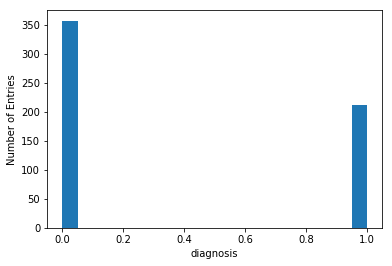

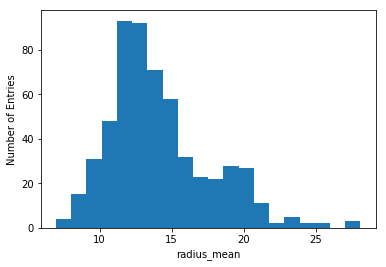

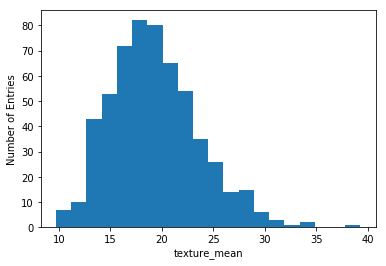

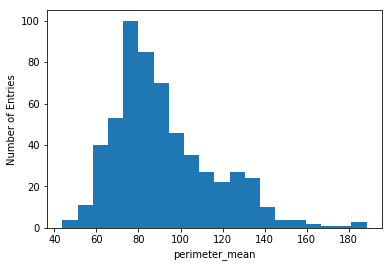

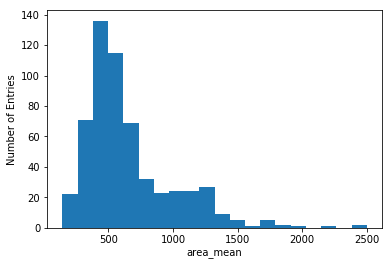

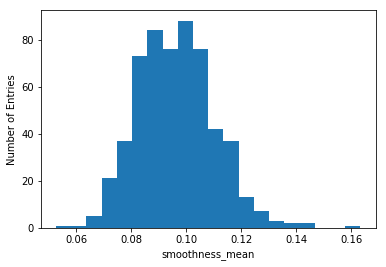

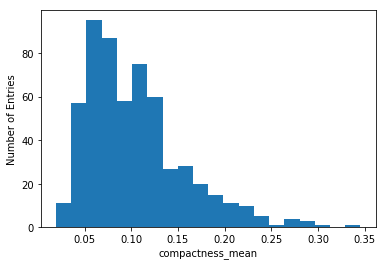

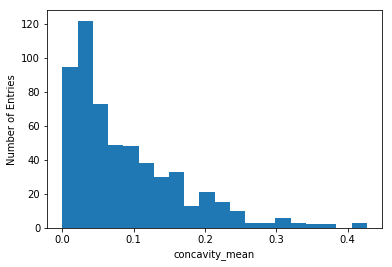

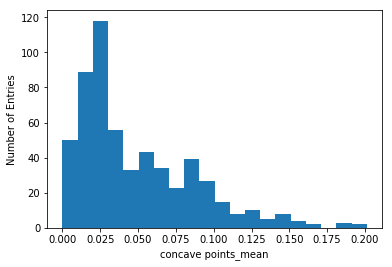

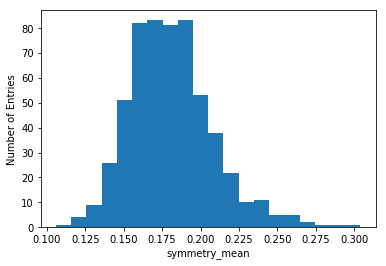

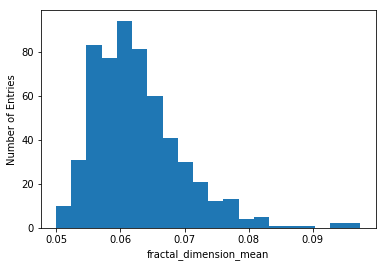

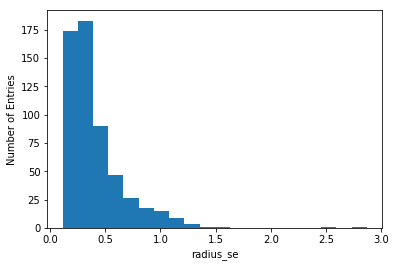

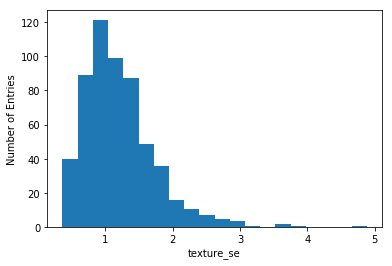

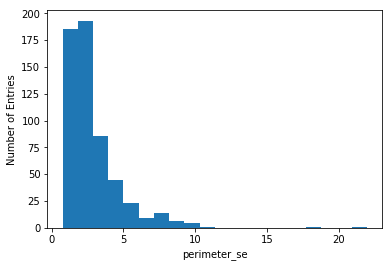

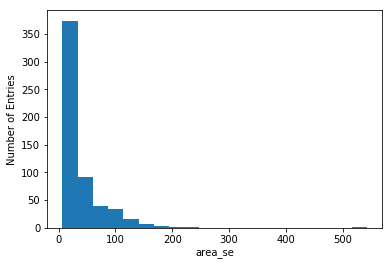

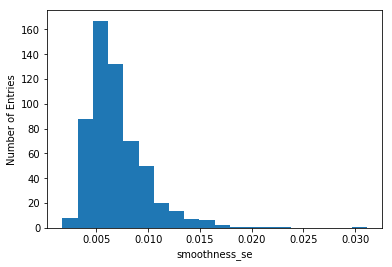

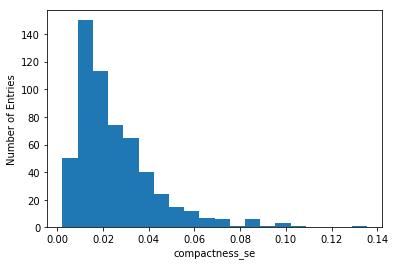

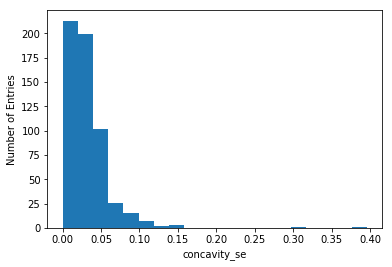

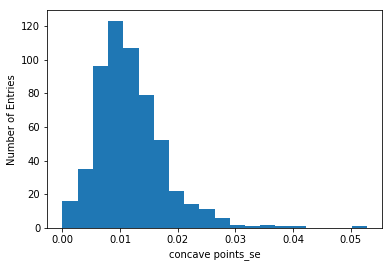

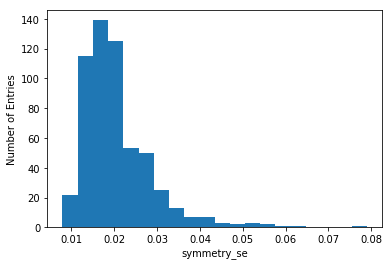

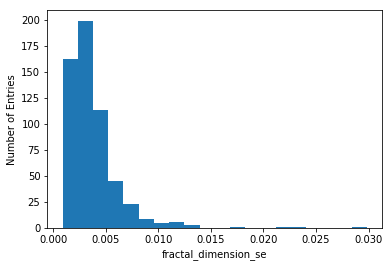

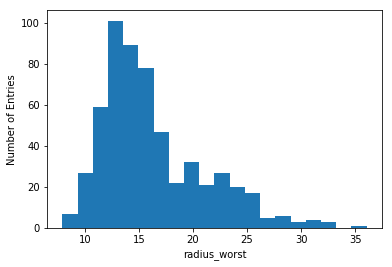

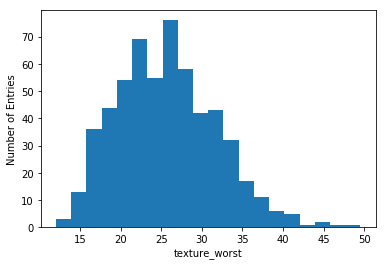

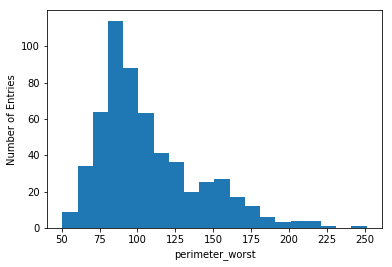

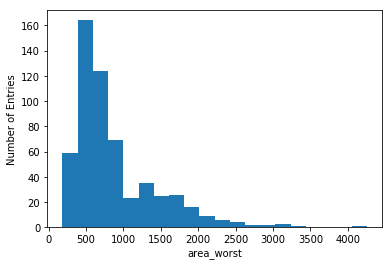

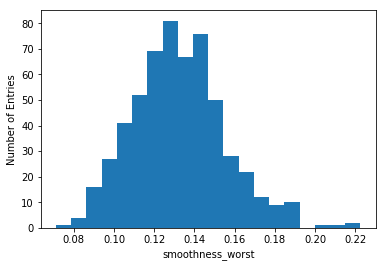

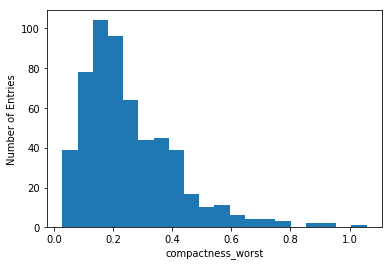

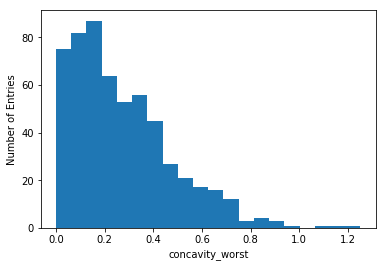

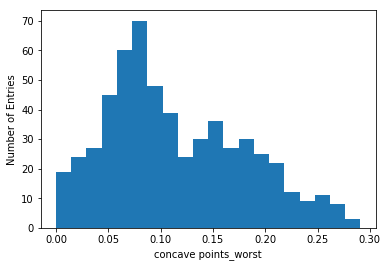

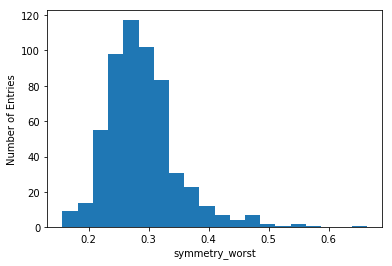

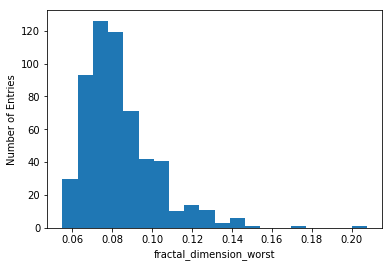

In [3]:
def plot_var(i,X):
    name = X.columns[i]
    plt.hist(X.iloc[:,i],bins=20)
    plt.xlabel(name)
    plt.ylabel('Number of Entries')
    plt.show()

for i in range(data.shape[1]):
    plot_var(i,data)

We see that the diagnosis, which we want to predict, is not perfectly balanced. There are substantially more benign entries.

We also see that many of our features have asymmetric distributions. Some even look exponential! When we later run PCA, it turns out that this is not ideal. PCA rests on the assumption that the data follow a multivariate Gaussian distribution, while that will obviously not be the case here. However, we get very good results without trying to address this, so there will be little to gain from trying to unskew the data.

We can now check to be sure that there are no NaN values and then print out some basic statistics on each feature

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 842302 to 92751
Data columns (total 31 columns):
diagnosis                  569 non-null int64
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non-null float64
concave points_se         

In [5]:
data.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


I haven't bothered printing out the description for every feature, but we can already see that some have highly skewed distributions. For example, for area_mean, there is a large difference between the mean and the median, with the mean being much higher. This feature likely has a large positive skewness. This isn't necessarily a problem, but it is good to know that not everything follows a symmetrice distribution.

## Setting Up the Classification Problem

For now, I will define a function that will take a training set, a validation set, and a classification model, and then print the sklearn classification report.

In [6]:
def analyze(mod,X1,y1,X2,y2):
    mod.fit(X1,y1) 
    y1_pred = mod.predict(X1)
    y2_pred = mod.predict(X2)
    rep1 = classification_report(y1,y1_pred)
    rep2 = classification_report(y2,y2_pred)
    print('Training classification report:')
    print(rep1)
    print('Validation classification report:')
    print(rep2)

Now I can create the feature sets. For now, I'll just blindly take all features and then use train_test_split to get two independent data sets. The training set takes up 70% of the data and the remainder goes into a validation set.

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

y = data['diagnosis']
X = data.drop('diagnosis',axis=1)
print(X.head())
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=124,
                                                 test_size=0.3,stratify=y)

          radius_mean  texture_mean  perimeter_mean  area_mean  \
id                                                               
842302          17.99         10.38          122.80     1001.0   
842517          20.57         17.77          132.90     1326.0   
84300903        19.69         21.25          130.00     1203.0   
84348301        11.42         20.38           77.58      386.1   
84358402        20.29         14.34          135.10     1297.0   

          smoothness_mean  compactness_mean  concavity_mean  \
id                                                            
842302            0.11840           0.27760          0.3001   
842517            0.08474           0.07864          0.0869   
84300903          0.10960           0.15990          0.1974   
84348301          0.14250           0.28390          0.2414   
84358402          0.10030           0.13280          0.1980   

          concave points_mean  symmetry_mean  fractal_dimension_mean  \
id                     

### Logistic Regression

Now, I can just run logistic regression. This typically is implemented using a maximum likelihood framework, so unlike for basic linear regression problems that are doing linear least squares, we do not assume that the features are Gaussian. We also shouldn't need to normalize features, although that may help out the minimization process.

In [8]:
lr = LogisticRegression(C=1e10)
# the large C removes regularization so that we can more easily compare the different models
# that we are using in this notebook without having regularization complicating our discussions.
analyze(lr,X_train,y_train,X_test,y_test)

Training classification report:
             precision    recall  f1-score   support

          0       0.99      1.00      0.99       250
          1       0.99      0.99      0.99       148

avg / total       0.99      0.99      0.99       398

Validation classification report:
             precision    recall  f1-score   support

          0       0.93      0.96      0.94       107
          1       0.93      0.88      0.90        64

avg / total       0.93      0.93      0.93       171



So, we see that without doing any transformation of the data and without doing any tuning of the model, we get an f1-score of 0.90 for malignant tumors in the validation set. Of course, we see that the data has around a 60-40 split between benign and malignant diagnoses, so this may or may not be good enough depending on how the test is used. 

### ROC Curves and Precision-Recall Curves

We can also use a ROC curve to see how the results will change if we move the classification boundary. This lets us raise or lower things like the precision and recall in order to tune the classifier for the specific problem that we are solving.

The ROC curve is convenient because it gives results that are not dependent on the balance of the data.

The precision-recall curve is similar to the ROC curve but it uses the precision and recall, which are dependent on the balance of the data. This gives you a better sense of how your classifier is performing on the actual data set rather than how it performs separately on each class. Because precision and recall are defined as ratios, the precision-recall curve does not need to be a monotonic function.

ROC Area-under-curve for training set: 0.999
ROC Area-under-curve for validation set: 0.974


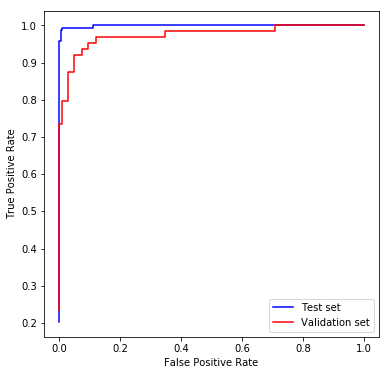

Ave. precision score for training set: 0.999
Ave. precision score for validation set: 0.97


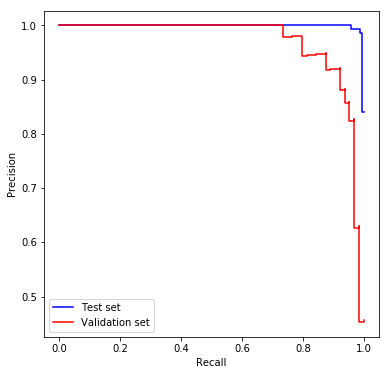

In [9]:
from sklearn import metrics

def analyze_roc(mod,X1,y1,X2,y2):
    ytrain_pred = mod.predict_proba(X1)
    ytest_pred = mod.predict_proba(X2)
    # Results have probabilities for results [0,1]

    roc_train = metrics.roc_curve(y1,ytrain_pred[:,1])
    roc_test = metrics.roc_curve(y2,ytest_pred[:,1])

    roc_auc_train = metrics.roc_auc_score(y1,ytrain_pred[:,1])
    roc_auc_test = metrics.roc_auc_score(y2,ytest_pred[:,1])

    print('ROC Area-under-curve for training set: {:0.3}'.format(roc_auc_train))
    print('ROC Area-under-curve for validation set: {:0.3}'.format(roc_auc_test))


    fig = plt.figure(1,figsize=[6,6])
    plt.plot(roc_train[0],roc_train[1],label='Test set',c='b')
    plt.plot(roc_test[0],roc_test[1],label='Validation set',c='r')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()
    
def analyze_prec_recall(mod,X1,y1,X2,y2):
    ytrain_pred = mod.predict_proba(X1)
    ytest_pred = mod.predict_proba(X2)
    # Results have probabilities for results [0,1]

    roc_train = metrics.precision_recall_curve(y1,ytrain_pred[:,1])
    roc_test = metrics.precision_recall_curve(y2,ytest_pred[:,1])

    roc_auc_train = metrics.average_precision_score(y1,ytrain_pred[:,1])
    roc_auc_test = metrics.average_precision_score(y2,ytest_pred[:,1])

    print('Ave. precision score for training set: {:0.3}'.format(roc_auc_train))
    print('Ave. precision score for validation set: {:0.3}'.format(roc_auc_test))


    fig = plt.figure(1,figsize=[6,6])
    plt.step(roc_train[1],roc_train[0],label='Test set',c='b')
    plt.step(roc_test[1],roc_test[0],label='Validation set',c='r')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower left')
    plt.show()
    
analyze_roc(lr,X_train,y_train,X_test,y_test)
analyze_prec_recall(lr,X_train,y_train,X_test,y_test)

A ROC AUC score of 1 indicates a perfect classifier. Here, our classifier has a ROC AUC score of 0.999 on the training set and 0.974 on the validation set. This is pretty good. In fact, we get a 100% precision if we accept a 75% recall. However, there is probably a considerable uncertainty due to the small statistics. 

### Determining the Uncertainty on These Scores

I'm not going to do this right now, but there are a few ways to determine an approximate uncertainty on our result. One way would be to do a k-fold cross validation and then calculate the mean and standard deviation of the validation scores. With such a small dataset, even this might be unreliable unless we use a small number of folds.

Another way would be to make bootstrap samples by generating random samples with replacement from our training and validation sets. Bootstrap samples of the training set can give us a sense of the uncertainty due to the fitting process, whil the samples based on the validation set can give us a sense of the uncertainty due to our choice of validation set. Both of these may be important to know.

## Feature Scaling and Reduction Using PCA

This data has 30 features that it can use to do do a binary classification. For a dataset with hundreds of entries, this is not a problem, but if this were to be expanded to millions, we might wonder how to reduce the size in order to speed up computations and reduce the memory footprint.

One standard way to do this is to use Principal Components Analysis (PCA) to determine linear combinations of features with the widest distributions. We might expect that linear combinations with very small widths may not be useful because all entries have nearly the same value.

PCA is also convenient because its results are easy to understand. It is basically just calculating the eigenvectors of the feature covariance matrix and then ordering them by the size of the eigenvalues. Because we want to use PCA to choose the best features, it's important to scale the data. Otherwise features with large numerical values will dominate the PCA result even if they are not necessarily that useful.

Here, I will use the StandardScaler() from sklearn. This just shifts and scales each feature to have a 0 mean and variance of 1.

In [10]:
st_sc = StandardScaler()

X_train = st_sc.fit_transform(X_train)
X_test = st_sc.transform(X_test)

Now I will run PCA. I'm just going to keep every new feature for now, but there is an n_feat keyword to automatically choose only a given number of features.

In [11]:
from sklearn.decomposition import PCA

pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

PCA has an "explained variance ratio" describing how much of the variance in the data set is described by each variable. The cumulative sum tells us how much of the variance is described by the first N variables.

In [12]:
exp_var = pca.explained_variance_ratio_.cumsum()
print(exp_var)

[ 0.42940949  0.62574355  0.72389479  0.7899425   0.84836263  0.88815377
  0.91096181  0.92795688  0.94167399  0.95434973  0.96341242  0.97184833
  0.97900912  0.98384508  0.98728537  0.98972517  0.99169924  0.99342557
  0.99487248  0.99591203  0.99684822  0.9977297   0.99845631  0.99905218
  0.99941051  0.99969567  0.99991513  0.99996752  0.99999543  1.        ]


We see that the first variable holds nearly half of the total variance, while the first two describe nearly 2/3. 

To choose variables describing 95% and 99% of the total variance, we'll need to use 10 and 17 variables, respectively. These would give us large savings in data size.

### Logistic regression on PCA-transformed data

But, how do we do if we just run logistic regression on these new variables. 

In [13]:
analyze(lr,X_train[:,:],y_train,X_test[:,:],y_test)

Training classification report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       250
          1       1.00      1.00      1.00       148

avg / total       1.00      1.00      1.00       398

Validation classification report:
             precision    recall  f1-score   support

          0       0.95      0.96      0.96       107
          1       0.94      0.92      0.93        64

avg / total       0.95      0.95      0.95       171



ROC Area-under-curve for training set: 1.0
ROC Area-under-curve for validation set: 0.987


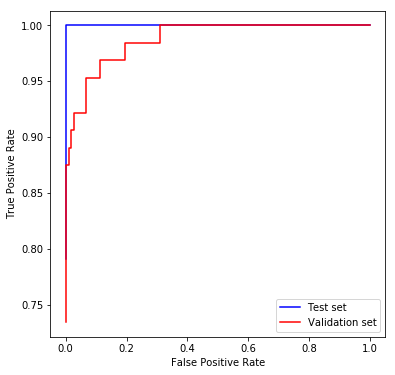

Ave. precision score for training set: 1.0
Ave. precision score for validation set: 0.983


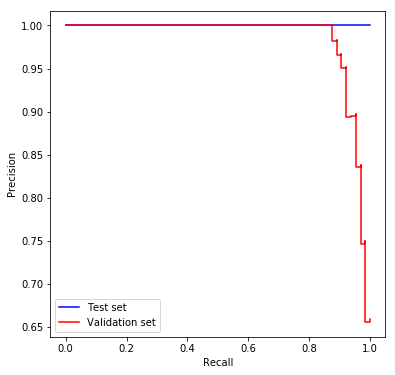

In [14]:
analyze_roc(lr,X_train,y_train,X_test,y_test)
analyze_prec_recall(lr,X_train,y_train,X_test,y_test)

This does better than our original fit (note the suppressed y-scale on the ROC curve plot. Yet, we've only applied linear transformations. This model and our original one are basically equivalent. So why does the PCA model do better? My suspicion is that both the scaling (putting all features on the same scale) and the PCA, which helps to reduce correlations between variables, make the optimization more efficient. Perhaps with a better optimizer we could find this solution on the original variables.

### Reducing the Number of Variables

Now, we can see how the number of variables in our PCA-transformed space affects our predictions. I will use the ROC AUC score as the metric to evaluate this.

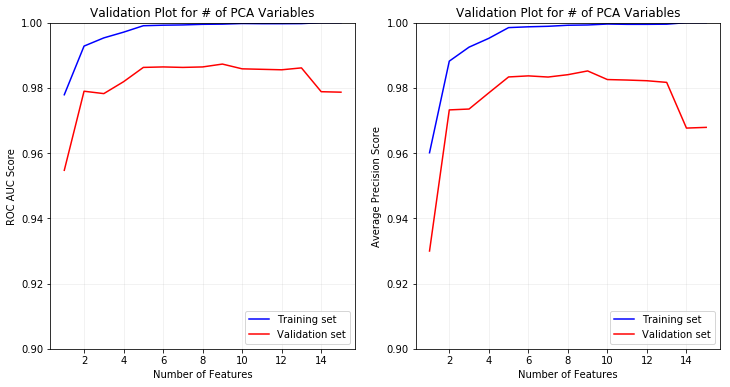

In [15]:
nfeat = 15

features = np.array([x for x in range(1,nfeat+1)])
train_score = np.zeros(nfeat)
val_score = np.zeros(nfeat)
train_score_2 = np.zeros(nfeat)
val_score_2 = np.zeros(nfeat)

for i in range(1,nfeat+1):
    #print('First {} PCA variable(s)\n\n'.format(i))
    lr.fit(X_train[:,:i],y_train)
    #print(i)
    train_prob = lr.predict_proba(X_train[:,:i])[:,1]
    test_prob = lr.predict_proba(X_test[:,:i])[:,1]
    #print(test_prob)
    
    train_score[i-1] = metrics.roc_auc_score(y_train,train_prob)
    val_score[i-1] = metrics.roc_auc_score(y_test,test_prob)
    
    train_score_2[i-1] = metrics.average_precision_score(y_train,train_prob)
    val_score_2[i-1] = metrics.average_precision_score(y_test,test_prob)
    
fig = plt.figure(1,figsize=[12,6])
ax = fig.add_subplot(121)
ax.plot(features,train_score,label='Training set',c='b')
ax.plot(features,val_score,label='Validation set',c='r')

ax.set_xlabel('Number of Features')
ax.set_ylabel('ROC AUC Score')
ax.set_title('Validation Plot for # of PCA Variables')
ax.legend(loc='lower right')
ax.set_ylim([0.9,1])
ax.grid(alpha=0.2,linestyle='-')

ax = fig.add_subplot(122)
ax.plot(features,train_score_2,label='Training set',c='b')
ax.plot(features,val_score_2,label='Validation set',c='r')

ax.set_xlabel('Number of Features')
ax.set_ylabel('Average Precision Score')
ax.set_title('Validation Plot for # of PCA Variables')
ax.legend(loc='lower right')
ax.set_ylim([0.9,1])
ax.grid(alpha=0.2,linestyle='-')

plt.show()

We actually see here that we get the best results on the validation around 9 features for both metrics, but even 5 is almost as good. So, we can reduce the size of our data by around 80% and still get just as good (or even better) results, assuming that the data balance is not too far from the true balance. Even 2 features isn't bad. I haven't plotted this, but I also notice some weird effects around 17 features (a sudden drop of a few hundredths in the validation score paired with an overflow warning) that might indicate a bug somewhere in the code.

### Other Scores

I could also look at something like the F1 score. Like the average precision score, this is sensitive to the ratio of malignant to benign entries. In this case, we might have to be careful how we report the score. Depending on where we set our classification threshold, we might get very different scores. For feature reduction, we might want to report the score at the optimal threshold for each number of features. 

## How Much Data Do I Really Need?

Because we have very high scores just from a simple logistic regression, we might ask how much data we really need to get good results. A learning curve is a good way to see this. I will use the 5-feature PCA feature set.

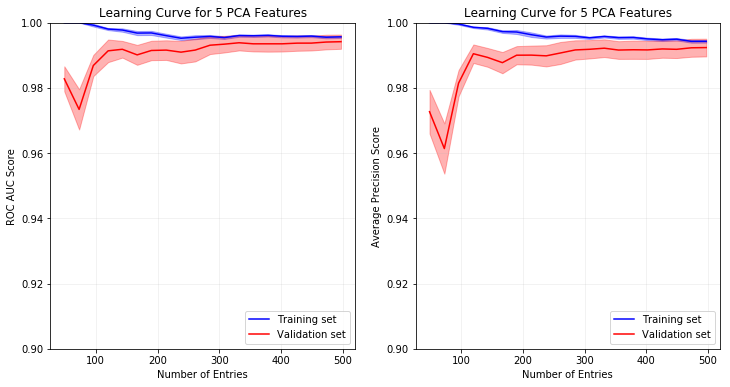

In [16]:
from sklearn import model_selection
from sklearn.pipeline import Pipeline
import warnings

# Get lots of warnings from exp for entries with very low probabilities
warnings.filterwarnings('ignore')

# Need to make my classifier to deal with shape of predict_proba output

class MyClassifier(LogisticRegression):
    def __init__(self,C=1e10,penalty='l2'):
        super(MyClassifier,self).__init__(C=C,penalty=penalty)
        
    def predict_proba(self,X):
        return super(MyClassifier,self).predict_proba(X)[:,1]
                                            
mylr = MyClassifier(C=1e10)
pca5 = PCA(n_components=5)

# Want to test all steps in the pipeline
my_pipeline = Pipeline((['Scaler',st_sc],['PCA',pca5],['LogReg',mylr]))
    
# Make scorers to pass to the learning_curve function
roc_scorer = metrics.make_scorer(metrics.roc_auc_score,needs_proba=True)
prec_scorer = metrics.make_scorer(metrics.average_precision_score,needs_proba=True)

# Create the learning curves
roc_size,roc_train,roc_test = model_selection.learning_curve(my_pipeline,X.as_matrix(),y,cv=8,
                                scoring = roc_scorer,train_sizes=np.linspace(0.1,1.0,20))
prec_size,prec_train,prec_test = model_selection.learning_curve(my_pipeline,X.as_matrix(),y,cv=8,
                                scoring = prec_scorer,train_sizes=np.linspace(0.1,1.0,20))

# Plot the curves
fig = plt.figure(1,figsize=[12,6])
ax = fig.add_subplot(121)

# Means and standard errors
roc_mean_train = np.mean(roc_train,axis=1)
roc_std_train = np.std(roc_train,axis=1)/np.sqrt(8)
roc_mean_test = np.mean(roc_test,axis=1)
roc_std_test = np.std(roc_test,axis=1)/np.sqrt(8)

ax.plot(roc_size,roc_mean_train,label='Training set',c='b')
ax.fill_between(roc_size,roc_mean_train-roc_std_train,
                roc_mean_train+roc_std_train,color='b',alpha=0.3)

ax.plot(roc_size,roc_mean_test,label='Validation set',c='r')
ax.fill_between(roc_size,roc_mean_test-roc_std_test,
                roc_mean_test+roc_std_test,color='r',alpha=0.3)

ax.set_xlabel('Number of Entries')
ax.set_ylabel('ROC AUC Score')
ax.set_title('Learning Curve for 5 PCA Features')
ax.legend(loc='lower right')
ax.set_ylim([0.9,1])
ax.grid(alpha=0.2,linestyle='-')


ax = fig.add_subplot(122)

# Means and standard errors
prec_mean_train = np.mean(prec_train,axis=1)
prec_std_train = np.std(prec_train,axis=1)/np.sqrt(8)
prec_mean_test = np.mean(prec_test,axis=1)
prec_std_test = np.std(prec_test,axis=1)/np.sqrt(8)

ax.plot(prec_size,prec_mean_train,label='Training set',c='b')
ax.fill_between(prec_size,prec_mean_train-prec_std_train,
                prec_mean_train+prec_std_train,color='b',alpha=0.3)

ax.plot(prec_size,prec_mean_test,label='Validation set',c='r')
ax.fill_between(prec_size,prec_mean_test-prec_std_test,
                prec_mean_test+prec_std_test,color='r',alpha=0.3)

ax.set_xlabel('Number of Entries')
ax.set_ylabel('Average Precision Score')
ax.set_title('Learning Curve for 5 PCA Features')
ax.legend(loc='lower right')
ax.set_ylim([0.9,1])
ax.grid(alpha=0.2,linestyle='-')

plt.show()

warnings.filterwarnings('default')

These plots show the means and the standard errors from a 8-fold stratified cross validation. We see that the results on the validation set start to level off around 150 total entries. It looks like there is still a slight slope to the validation set curve and a slight difference between the training and validation sets, so we may be able to get a small improvement better results with a lot more data. It would probably be much more productive to either go back to the underlying data that was used to build this set to construct new features, construct new non-linear features from what is already here (such as polynomial features), or to use a different approach to the analysis.

## L1 Regularization: An Alternative Way to Select Features

We have seen that choosing the 5 top features from PCA gives us near-optimal results. But, we might wonder if maybe some of these are not very useful. It's certainly possible for a feature to have a wide distribution but also no bearing on the class. Another way to select features that are actually useful is to use L1 (Lasso) regularization. An interesting property of L1 regularization is that it tends to force many of the feature coefficients to 0, effectively removing features that aren't providing much information from our fit.



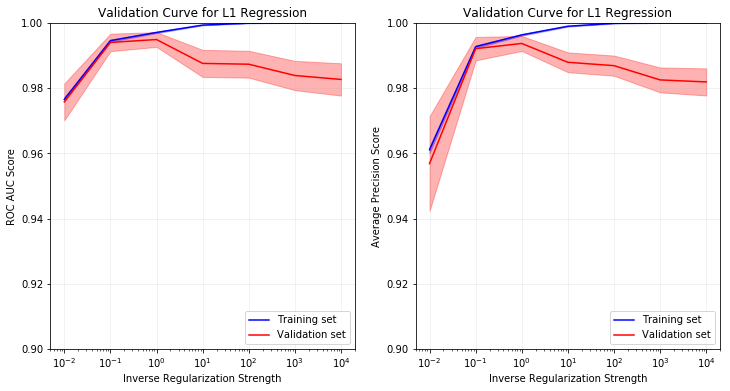

In [17]:
from sklearn.model_selection import validation_curve
warnings.filterwarnings('ignore')

# Transform the full dataset with my pca transformation
st_sc.fit(X)
X_feat = st_sc.transform(X)
pca.fit(X_feat)
X_feat = pca.transform(X_feat)

mylr = MyClassifier(C=1e10,penalty='l1')

c_val = [0.01,0.1,1,10,100,1000,10000]

roc_train,roc_test = model_selection.validation_curve(mylr,X_feat,y,'C',c_val,cv=8,
                                scoring = roc_scorer)
prec_train,prec_test = model_selection.validation_curve(mylr,X_feat,y,'C',c_val,cv=8,
                                scoring = prec_scorer)

# Plot the curves
fig = plt.figure(1,figsize=[12,6])
ax = fig.add_subplot(121)

# Means and standard errors
roc_mean_train = np.mean(roc_train,axis=1)
roc_std_train = np.std(roc_train,axis=1)/np.sqrt(8)
roc_mean_test = np.mean(roc_test,axis=1)
roc_std_test = np.std(roc_test,axis=1)/np.sqrt(8)

ax.plot(c_val,roc_mean_train,label='Training set',c='b')
ax.fill_between(c_val,roc_mean_train-roc_std_train,
                roc_mean_train+roc_std_train,color='b',alpha=0.3)

ax.plot(c_val,roc_mean_test,label='Validation set',c='r')
ax.fill_between(c_val,roc_mean_test-roc_std_test,
                roc_mean_test+roc_std_test,color='r',alpha=0.3)

ax.set_xlabel('Inverse Regularization Strength')
ax.set_ylabel('ROC AUC Score')
ax.set_title('Validation Curve for L1 Regression')
ax.legend(loc='lower right')
ax.set_ylim([0.9,1])
ax.grid(alpha=0.2,linestyle='-')
ax.set_xscale('log')

ax = fig.add_subplot(122)

# Means and standard errors
prec_mean_train = np.mean(prec_train,axis=1)
prec_std_train = np.std(prec_train,axis=1)/np.sqrt(8)
prec_mean_test = np.mean(prec_test,axis=1)
prec_std_test = np.std(prec_test,axis=1)/np.sqrt(8)

ax.plot(c_val,prec_mean_train,label='Training set',c='b')
ax.fill_between(c_val,prec_mean_train-prec_std_train,
                prec_mean_train+prec_std_train,color='b',alpha=0.3)

ax.plot(c_val,prec_mean_test,label='Validation set',c='r')
ax.fill_between(c_val,prec_mean_test-prec_std_test,
                prec_mean_test+prec_std_test,color='r',alpha=0.3)

ax.set_xlabel('Inverse Regularization Strength')
ax.set_ylabel('Average Precision Score')
ax.set_title('Validation Curve for L1 Regression')
ax.legend(loc='lower right')
ax.set_ylim([0.9,1])
ax.set_xscale('log')
ax.grid(alpha=0.2,linestyle='-')

plt.show()

warnings.filterwarnings('default')

So in this case, we get the best results in a wide band around C~0.1-1. Let's see what happens when we set C=0.1, 1, and 10.

In [18]:
lr_l1 = LogisticRegression(C=10,penalty='l1')
lr_l1.fit(X_feat,y)
print('C=10')
print(np.where(lr_l1.coef_[0]==0)[0])

lr_l1 = LogisticRegression(C=1,penalty='l1')
lr_l1.fit(X_feat,y)
print('C=1')
print(np.where(lr_l1.coef_[0]==0)[0])

lr_l1 = LogisticRegression(C=0.1,penalty='l1')
lr_l1.fit(X_feat,y)
print('\nC=0.1')
print(np.where(lr_l1.coef_[0]==0)[0])


C=10
[15 16 24 25 26 27 28 29]
C=1
[11 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29]

C=0.1
[ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29]


We see that at C=10, 8 features are removed. At C=1, 17 features are removed. At C=0.1, 25 features are removed. In this case, we see that the 5 remaining features are the first 5, so C=0.1 gives us the same feature set as our initial method of just looking at first 5 PCA variables given the validation curve.

The exact values of the coefficients are likely to be different, as there is a penalty for having non-zero coefficients.

## Another Alternative Dimensionality Reduction Method: Recursive Feature Elimination

A third way that we could reduce the feature set would be to use Recursive Feature Elimination (RFE). The way this works is to first fit the model to the data. Then, we can see which feature has the smallest coefficient, eliminate it, and repeat until we have the desired number of features left. For this to work, we'll want to rescale our features since the coefficients depend on the scales. I will use the PCA variables as my feature set.

In [19]:
from sklearn.feature_selection import RFE

st_sc_rfe = StandardScaler()

X_feat_rfe = st_sc_rfe.fit_transform(X_feat)

rfe = RFE(lr,n_features_to_select=5)
X_feat_rfe = rfe.fit_transform(X_feat_rfe,y)

print(rfe.ranking_)

[ 1  1 21 20  1  5  1  3  1  8  7 23 25  6 19 17 10 16  2 13 24 22  4 26 18
 14 12  9 11 15]


We see that if we choose 5 features, RFE chooses features 0, 1, 4, 6, and 8. This is a different feature set than we got from either PCA or L1 regularization. The proper way to do this would be first to do cross validation to choose the number of features (there is an RFECV class to help with this). I won't plot the validation curves or a validation score here, but the methods to do this should be evident from the earlier work in this notebook.

## Conclusions

In this notebook, we've gone over a number of different topics using this small data set. We've looked at several ways to do dimensionality reduction, we've run a logistic regression and looked at how to tune individual parameters of our model, and we've gone over some different ways to plot results and report scores for binary classification data.